# Supervised Image Classification in Python

This notebook will walk you through how to do the supervised image classification that was completed in GEM 520 but this time we will complete it Python. It is recommended that you create a new folder with your training polygons and the raster image, as you do not want to overwrite any information from your lab for this process. We will only be going over the scripting part of the lab in this activity to show the differences between R and Python, so it is encouraged that you have your R scripts from that lab open as well to see what the similarities and differences are.

We have already installed the correct packages used in this script when you ran the `create_environment.py` script. Now we can import the packages that we will need to run this activity.

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from matplotlib.colors import ListedColormap
from rasterio.features import geometry_mask
from skimage import exposure
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

We will start by reading in the Landsat image into Python and plotting it.

*Note: This image can also be found [here](https://github.com/ubc-mgem-fcor599/FCOR-599-Workshops/tree/main/CodingCrossover/data) if you are unable to find the image from this assignment.*

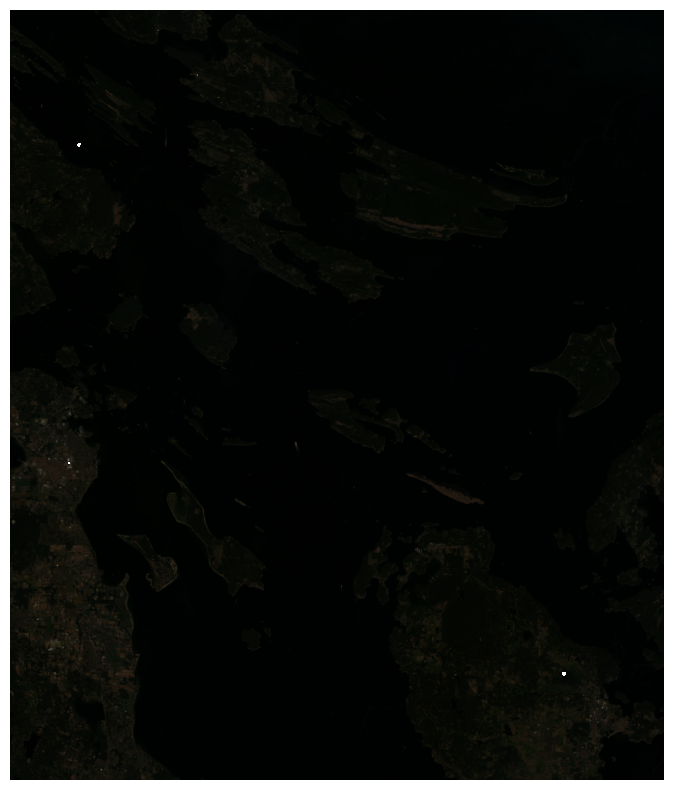

In [22]:
# Read in the Landsat image
with rasterio.open(
    r"D:\MurrayBrent\git\CodingCrossover\data\LC09_L2SP_047026_20240716_20240717_02_T1_SR_BSTACK.tif"
) as src:
    raster = src.read()  # read raster as an array
    transform = src.transform  # get the transform information

# Create a true colour composite
rgb_image = np.stack(
    (raster[2], raster[1], raster[0]),
    axis=-1,
)  # remember that python starts with 0

# Plot the true colour composite
plt.figure(figsize=(10, 10))  # initalize figure and set size
plt.axis("off")  # turn axis off for visualization
plt.imshow(rgb_image)  # show the true colour composite

You will notice when we plot this image that it is very dark and that there are some pixels that have a nan value. Below is a function that will implement an image stretch and replace the nan values with 0. We will then plot the true colour composite again.

In [23]:
def percentile_stretch(band, lower_percentile=2, upper_percentile=98):
    band[np.isnan(band)] = 0  # set nan values to 0
    band_min, band_max = np.percentile(
        band, (lower_percentile, upper_percentile)
    )  # get min and max values based on defined percentiles
    stretched_band = (band - band_min) / (
        band_max - band_min
    )  # perform stretch on band
    return np.clip(stretched_band, 0, 1)  # return band within value range (0-1)

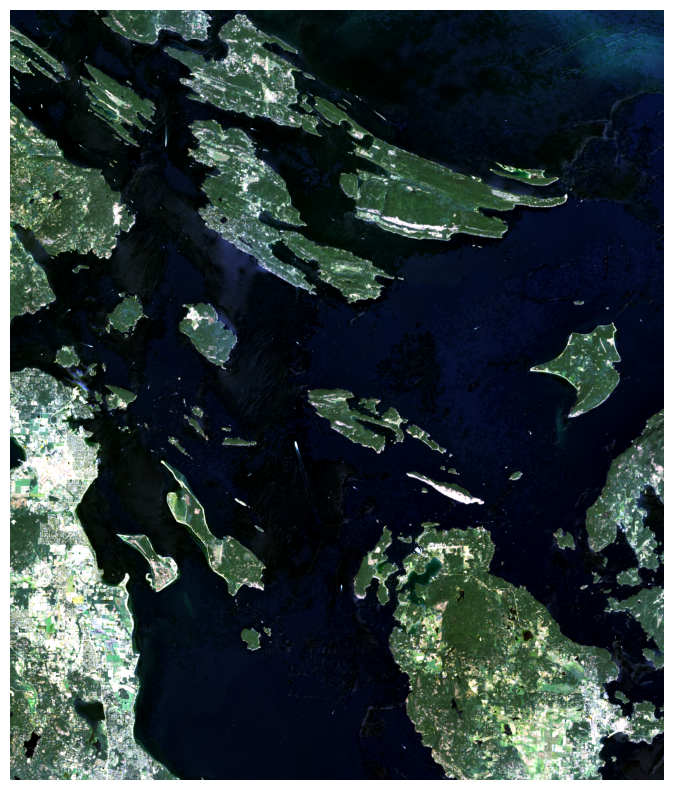

In [24]:
# Create a true colour composite with stretch
rgb_image = np.stack(
    (
        percentile_stretch(raster[2]),
        percentile_stretch(raster[1]),
        percentile_stretch(raster[0]),
    ),
    axis=-1,
)  # remember that python starts with 0

# Plot the true colour composite
plt.figure(figsize=(10, 10))  # initalize figure and set size
plt.axis("off")  # turn axis off for visualization
plt.imshow(rgb_image)  # show the true colour composite

Then, we load the delineated polygons and plot them with the image.

*Note: A version of these polygons can also be found [here](https://github.com/ubc-mgem-fcor599/FCOR-599-Workshops/tree/main/CodingCrossover/data) if you are unable to find your polygons from the original assignment.*

In [25]:
# Read in classification polygons as geopandas dataframe
gdf = gpd.read_file(
    r"D:\MurrayBrent\git\CodingCrossover\data\classification_polygons.shp"
)

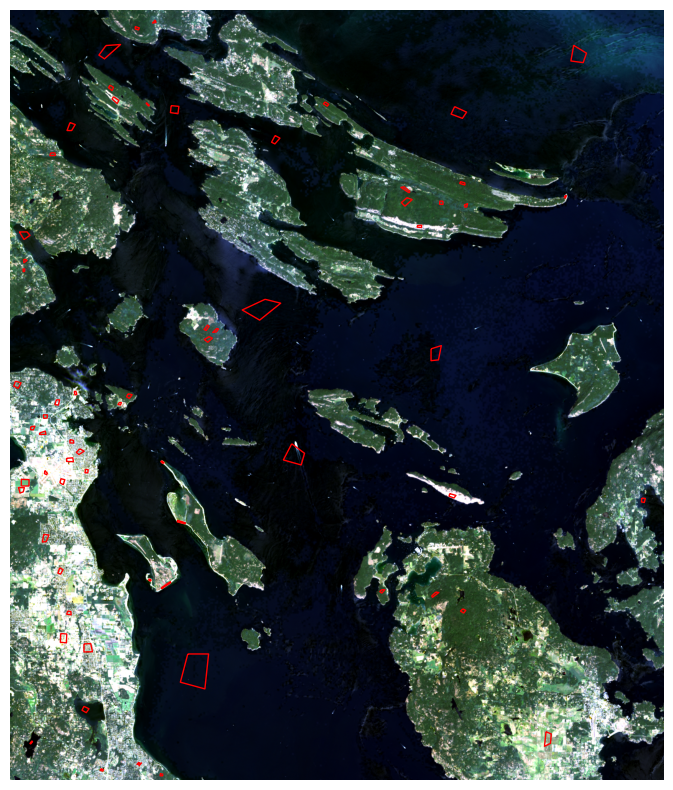

In [26]:
# Plot the image with the polygons
fig, ax = plt.subplots(figsize=(10, 10))  # initialize figure
ax.imshow(
    rgb_image,
    extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top),
)  # plot the image
gdf.boundary.plot(ax=ax, color="red", linewidth=1)  # plot the boundary of the polygons
plt.axis("off")  # turn axis off for visualization
plt.show()  # show full plot

You will notice when we plotted the polygon boundaries that we called it straight from the `geopandas` dataframe (gdf). Both `geopandas` and `pandas` have built in plotting using `matplotlib`, so we dont need to specifically call any `matplotlib` functions. The functions that are built into `geopandas` and `pandas` use the standard `matplotlib` convention, meaning you can edit and change the plots in the same way you would in `matplotlib`.

Here is a summary of the number of polygons per class.

In [27]:
poly_summary = gdf["lc_class"].value_counts()  # get a count of the `lc_class` field
poly_summary

lc_class
Water                     14
Broadleaf Forest          11
Coniferous Forest         10
Low density developed      9
Exposed soil and rocks     8
High density developed     7
Non-forest vegetation      7
Name: count, dtype: int64

For each land cover class, we will use 70% of the polygons to train the classification algorithm and the remaining 30% for validation. We are going to add a column to the dataframe called 'set' to identify which polygons will be used for training and which will be used for validation based on a stratified random sample of the 'lc_class' column. We will then split the dataframe into two one for training and one for validation.

In [28]:
# Encode 'lc_class' so that it is a class number (factor in R)
gdf["lc_class_encoded"] = gdf["lc_class"].astype("category").cat.codes

In [29]:
# Split the data into a 70:30 split
train_idx, val_idx = train_test_split(
    gdf.index, test_size=0.3, stratify=gdf["lc_class"], random_state=1234
)  # stratified random sample based on 'lc_class'

# Create new column 'set'
gdf["set"] = "Training"  # set default value to training
gdf.loc[val_idx, "set"] = "Validation"  # replace value with 'Validation'

# Create a Training and a Validation dataframe
train_gdf = gdf[gdf["set"] == "Training"]  # training dataframe
val_gdf = gdf[gdf["set"] == "Validation"]  # validation dataframe

We now need to get the raster data ready to perform the maximum likelihood classification. We need to get the shape of the raster, replace any nan values, and flatten the raster for easier processing.

In [30]:
# Preprocess raster for classificaiton
(
    B,  # band
    H,  # height
    W,  # width
) = raster.shape  # get shape of raster
raster = np.nan_to_num(raster, nan=0)  # replace nan to 0
flattened_raster = raster.reshape(B, -1).T  # Flatten raster to shape (H*W, B)

Now we can extract the values of the Landsat image based on the training polygons.

In [31]:
# Prepare training data
x_train, y_train = [], []  # empty lists for pixel values and labels
for idx, row in train_gdf.iterrows():  # iterate through each polygon
    # Generate a mask for the polygon
    mask = geometry_mask(
        [row.geometry], transform=transform, invert=True, out_shape=(H, W)
    )

    # Collect pixel values and labels
    pixels = flattened_raster[mask.flatten()]  # extract pixel values
    labels = np.full(len(pixels), row["lc_class_encoded"])  # get label

    # Append to lists
    x_train.append(pixels)
    y_train.append(labels)

# Concatenate training data
x_train = np.vstack(x_train)
y_train = np.concatenate(y_train)

The maximum likelihood classification will be performed using the `GaussianNB()` Function from the `scikit-learn` package. The `GaussianNB()` function implements the Gaussian Naive Bayes algorithm for classification. This function fits to the training data we extracted in the previous step and then predicting the class for each pixel in the raster image.

In [32]:
# Train maximum likeihood classifier (Gaussian Naive Bayes)
classifier = GaussianNB()  # call model to use
classifier.fit(x_train, y_train)  # fit/train model to training data

# Classify entier raster
predicted = classifier.predict(flattened_raster)  # predict class to each pixel
classified_raster = predicted.reshape(
    H, W
)  # reshape prediction from flattened raster to original dimensions

Now let's plot the classified raster to see how this model worked.

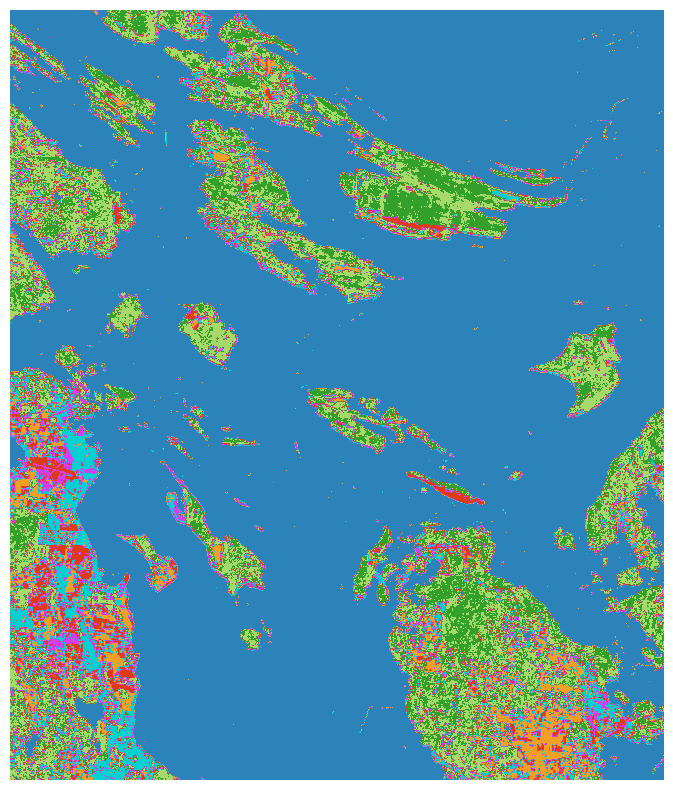

In [33]:
# Set appropriate colours for each class
colors = ["#A6D96A", "#33A02C", "#DE3B13", "#D63CF1", "#00D2D2", "#F1A026", "#2B83BA"]
cmap = ListedColormap(colors)

# Plot classified image
plt.figure(figsize=(10, 10))  # initialize figure and set size
plt.axis("off")  # turn axis off for visualization
plt.imshow(classified_raster, cmap=cmap)  # plot classified raster with defined colours

Using the validation polygons, we can extract the predicted classes and the *'true'* values so we can calculate our accuracy metrics and create a confusion matrix.

In [14]:
# Prepare validation data
true_classes, predicted_classes = [], []  # empty lists for true and predicted classes
for idx, row in val_gdf.iterrows():  # iterate through each polygon
    # Generate a mask for the polygon
    mask = geometry_mask(
        [row.geometry], transform=transform, invert=True, out_shape=(H, W)
    )

    # Extract true clas labels
    true_label = row["lc_class_encoded"]  # Column with the true encoded class labels
    true_values = np.full(np.sum(mask), true_label)

    # Extract predicted class labels from classified raster
    predicted_values = classified_raster[mask]

    # Append to lists
    true_classes.extend(true_values)
    predicted_classes.extend(predicted_values)

# Convert lists to numpy arrays
true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

Now we can calculate the overall accuracy and F1 score.

In [15]:
# Calculate accuracy metrics and print values
oa = accuracy_score(true_classes, predicted_classes)  # overall accuracy
f1 = f1_score(true_classes, predicted_classes, average="weighted")  # f1 score
print(f"Overall Accuracy: {oa}\nF1 Score: {f1}")

Overall Accuracy: 0.9501295336787565
F1 Score: 0.9510636263135169


We can also create a confusion matrix and calculate the Producer's and User's accuracies.

In [36]:
# Create confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Calculate producers and users accuracies from confusion matrix
pa = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # producers accuracy
ua = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)  # users accuracy

# Create dataframe for confusion matrix
classes = np.unique(gdf["lc_class"])  # get unique class label
conf_matrix_df = pd.DataFrame(
    conf_matrix.T, index=classes, columns=classes
)  # create dataframe

# Add producers and users accuracies to dataframe
conf_matrix_df.loc["Producer's Accuracy"] = np.round(pa * 100, 3)
conf_matrix_df["User's Accuracy"] = np.append(
    np.round(ua * 100, 2), [np.nan]
)  # Append NaN for alignment

# Add titles to show which values are Predicted and which are Actual
conf_matrix_df.index.name = "Predicted"
conf_matrix_df.columns.name = "Actual"

# Print confusion matrix
conf_matrix_df

Actual,Broadleaf Forest,Coniferous Forest,Exposed soil and rocks,High density developed,Low density developed,Non-forest vegetation,Water,User's Accuracy
Predicted,,,,,,,,
Broadleaf Forest,71.00,13.000,0.000,0.000,18.000,0.000,0.000,69.61
Coniferous Forest,1.00,100.000,0.000,0.000,2.000,0.000,0.000,97.09
Exposed soil and rocks,0.00,0.000,75.000,1.000,2.000,7.000,0.000,88.24
High density developed,0.00,0.000,9.000,41.000,2.000,0.000,1.000,77.36
Low density developed,0.00,0.000,15.000,3.000,367.000,0.000,0.000,95.32
Non-forest vegetation,1.00,0.000,0.000,0.000,2.000,178.000,0.000,98.34
Water,0.00,0.000,0.000,0.000,0.000,0.000,635.000,100.00
Producer's Accuracy,97.26,88.496,75.758,91.111,93.384,96.216,99.843,NaN
